# Iris Flowers Dataset Project

Thousands of years ago, the identification of a sweet, energy-filled berry versus a poisonous one was a matter of life and death. Foragers built up an intuition for classifying plants over generations in order to survive. In 2022, we are lucky to not have to worry about whether our store-bought blackberries will kill us. As well, we are armed with complex instruments to measure objects far better than our own senses can. From rulers to digital twins, plants can now be systematically measured. Our particular plant of focus is irises. 

For context, irises are a type of flower with over 350 species. Iris flowers are distinguished by their sepals and petals, which are the main distinguishing features that differentiate one type of iris from another. The sepals and petals can be further broken down into the widths and heights of each.

The dataset we will use to answer our research question is the [Iris Plant Database](https://archive.ics.uci.edu/ml/datasets/iris) created by R.A. Fisher, which is found in the UCI Machine Learning Repository.
This dataset was actually created in 1936, meaning that it was not originally created to be used with code. It also has no missing values.
Unfortunately, one of the limitations with the data set is that it only has 150 instances, which can impact our accuracy or how the data is split.

It contains three classes, which are the Iris species `Iris Setosa`, `Iris Versicolour`, and `Iris Virginica`.
These Irises are particularly difficult to differentiate for having similar colors.
The predictors for the classes are the `sepal length`, `sepal width`, `petal length`, and `petal width`, all measured in `centimeters`.
In our exploration, we will use these attributes to predict which of the three Iris plants a given flower is.

**All this leads to our classification question:**<br>
`Given an Iris' lengths and widths of its petals and sepals, is it an Iris Setosa, Iris Versicolour, or Iris Virginica?`

<img style="display: block; margin-left: auto; margin-right: auto; width: 50%; width: 75%" src="https://editor.analyticsvidhya.com/uploads/51518iris%20img1.png"></img><br>
<p style="text-align:center"><a href="https://azkarohbiya.medium.com/iris-species-classification-using-k-neighbors-ae61cd145797">Image Source</a></p>

## Methods and Results

In [16]:
# Load the packages we need
library(tidyverse)
library(tidymodels)

options(repr.plot.width = 10, repr.plot.height = 8)
options(repr.matrix.max.rows = 6)

In [2]:
# Grab our data and tidy it
# We need to turn our class into a factor using mutate

url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
iris_data <- read_csv(url, col_names = c("sepal_length", "sepal_width", "petal_length", "petal_width", "class"), show_col_types = FALSE) |>
    mutate(class = as_factor(class))

iris_data

sepal_length,sepal_width,petal_length,petal_width,class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
5.1,3.5,1.4,0.2,Iris-setosa
4.9,3.0,1.4,0.2,Iris-setosa
4.7,3.2,1.3,0.2,Iris-setosa
⋮,⋮,⋮,⋮,⋮
6.5,3.0,5.2,2.0,Iris-virginica
6.2,3.4,5.4,2.3,Iris-virginica
5.9,3.0,5.1,1.8,Iris-virginica


<div style="color:gray">Table 1: Scatter plot of sepal widths and lengths.</div><br>

From <i>Table 1</i>, we can see that the Iris dataset contains the following predictors:
* `sepal_length` - Sepal length of iris (cm)
* `sepal_width` - Sepal width of iris (cm)
* `petal_length` - Petal length of iris (cm)
* `petal_width` - Petal width of iris (cm)

And the following class:<br>
* `class` - Species of iris

In [3]:
set.seed(2022)

# Splitting our training set and testing set
iris_split <- initial_split(iris_data, prop = 0.75, strata = class)
iris_test <- testing(iris_split) # Don't touch testing set until the end
iris_train <- training(iris_split)

### Preliminary Exploratory Data Analysis

#### Distribution of classes in our training set

In [4]:
class_count <- iris_train |>
    group_by(class) |>
    summarize(n = n()) |>
    mutate(percentage = 100 * n / nrow(iris_train))

class_count

class,n,percentage
<fct>,<int>,<dbl>
Iris-setosa,37,33.33333
Iris-versicolor,37,33.33333
Iris-virginica,37,33.33333


<div style="color:gray">Table 2: Distribution of classes in our training set.</div><br>
As the iris dataset has 50 observations of each iris species, each class takes up 1/3rd of our training set, thus there is no underrepresentation of any class.<br>
This means our data is well-distributed and no further action to balance our data is required.

#### Differences Between Iris Species

In [5]:
predictors_mean <- iris_train |>
    group_by(class) |>
    summarize(sepal_length_mean = mean(sepal_length),
              sepal_width_mean = mean(sepal_width),
              petal_length_mean = mean(petal_length),
              petal_width_mean = mean(petal_width))

predictors_mean

class,sepal_length_mean,sepal_width_mean,petal_length_mean,petal_width_mean
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Iris-setosa,5.016216,3.424324,1.451351,0.2432432
Iris-versicolor,5.927027,2.762162,4.248649,1.3081081
Iris-virginica,6.524324,2.972973,5.491892,1.9918919


<div style="color:gray">Table 3: Mean of Each Variable Per Class</div><br>

*Table 3* helps us understand the differences between each class.
For petal length and width, we can make the following observations:
- Iris Setosa have both the shortest petal lengths and petal widths
- Iris Virginia have both the longest petal lengths and petal widths
- The petal length and width of the Iris Versicolor lies in the middle. 

For sepal length and width, we can make the following observations:
- Iris Setosa species have a shorter sepal length and shorter sepal width
- Iris Virginica tend to have longer sepal lengths but shorter sepal widths
- Iris Versicolor tend to have longer sepal lengths but shorter sepal widths


#### Plotting Iris Sepal  Dimensions

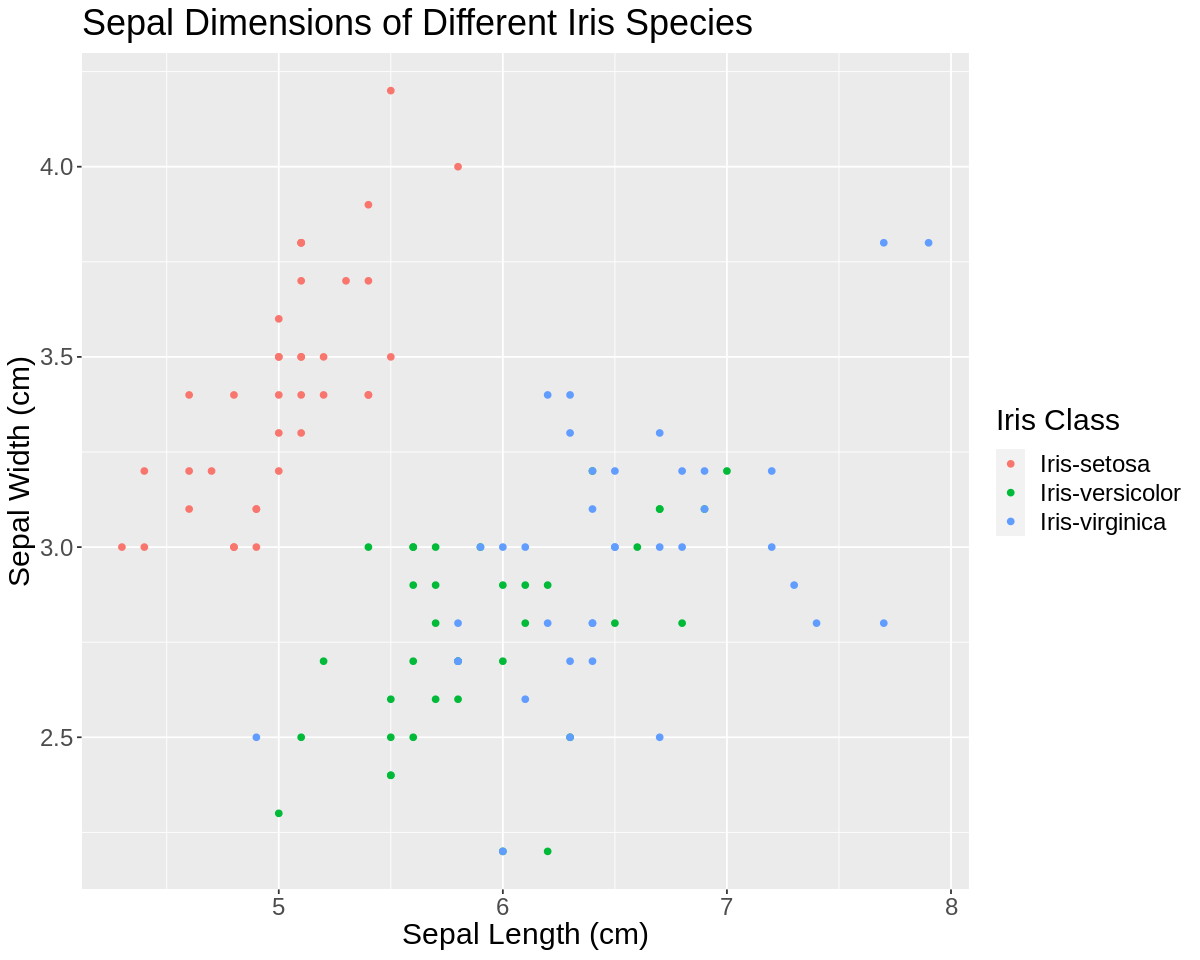

In [6]:
iris_petal_plot <- iris_train |>
    ggplot(aes(x = sepal_length, y = sepal_width, color = class)) +
    geom_point() +
    labs(x = "Sepal Length (cm)", y = "Sepal Width (cm)", color = "Iris Class", title = "Sepal Dimensions of Different Iris Species") +
    theme(text = element_text(size=18))

iris_petal_plot

<div style="color:gray">Figure 1: Scatter plot of sepal widths and lengths.</div><br>
In <i>Figure 1</i>, we can see that sepal dimensions has noticeable overlaps between different species.

#### Plotting Iris Petal Dimensions

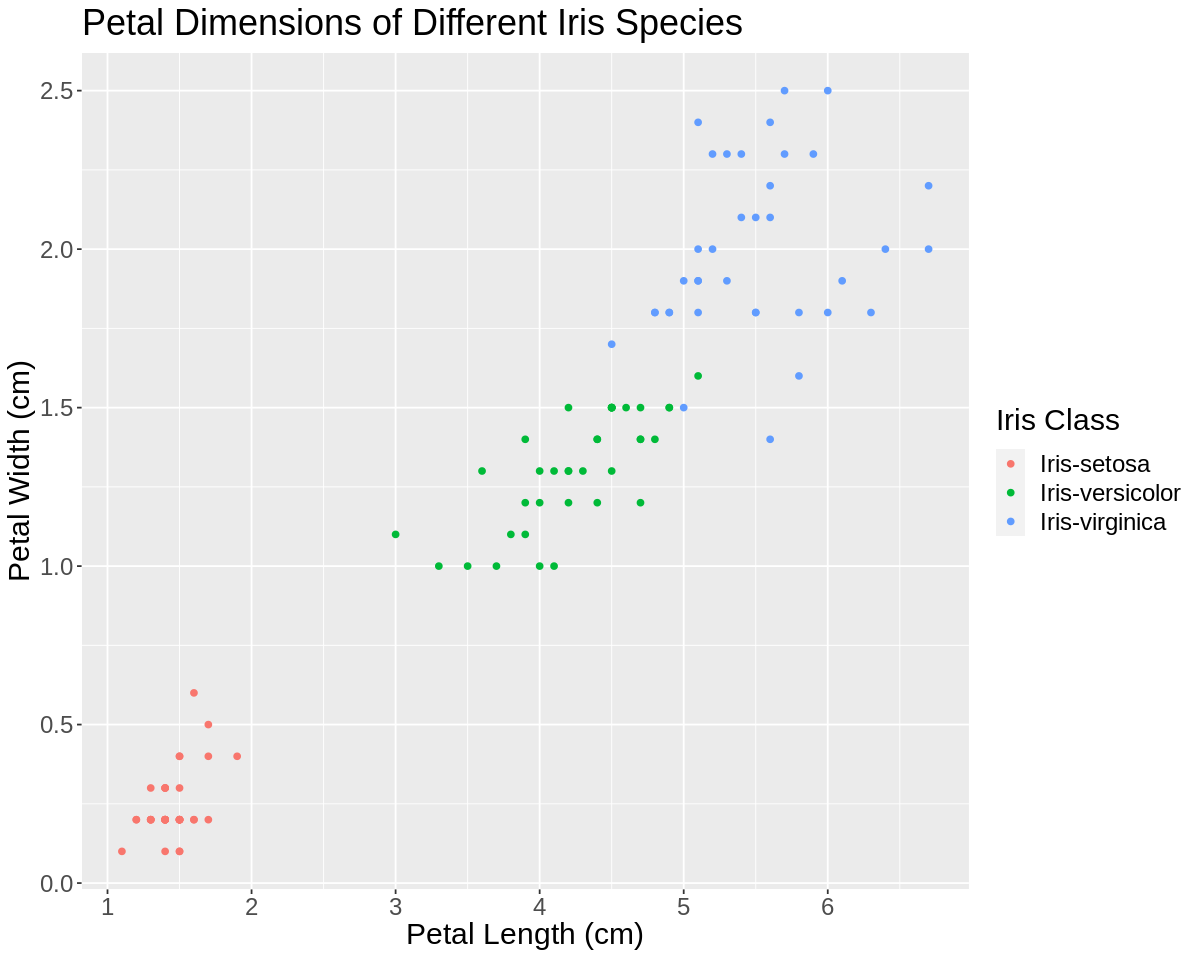

In [7]:
iris_petal_plot <- iris_train |>
    ggplot(aes(x = petal_length, y = petal_width, color = class)) +
    geom_point() +
    labs(x = "Petal Length (cm)", y = "Petal Width (cm)", color = "Iris Class", title = "Petal Dimensions of Different Iris Species") +
    theme(text = element_text(size=18))

iris_petal_plot

<div style="color:gray">Figure 1.1: Scatter plot of petal widths and lengths.</div><br>

In *Figure 1.1*, we can see that by using petal dimensions, there is no significant overlap.<br>

While there are patterns for both sepal and petal measurements, in *Figure 1* (sepal dimensions), we could see there were many overlapping points, specifically between Iris Virginica and Iris Versicolor.<br>
However, in *Figure 1.1* (petal dimensions), there is no significant overlap between the three species, deeming the petal dimensions to be more effective predictors for species of an Iris plant.

#### Forward Selection

Lets confirm our hypothesis with forward selection which helps us find a good set of predictors to use. 

In [8]:
set.seed(5432)

names <- colnames(iris_train |> select(-class))

# create an empty tibble to store the results
fs_accuracies <- tibble(size = integer(), 
                        model_string = character(), 
                        accuracy = numeric())

# create a model specification
fs_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5-fold cross-validation object
fs_vfold <- vfold_cv(iris_train, v = 5, strata = class)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("class", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        fs_recipe <- recipe(as.formula(model_string), data = iris_train) |>
            step_scale(all_predictors()) |>
            step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(fs_recipe) |>
          add_model(fs_spec) |>
          tune_grid(resamples = fs_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    fs_accuracies <- fs_accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
fs_accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,class ~ petal_width,0.9738095
2,class ~ petal_width+petal_length,0.9916667
3,class ~ petal_width+petal_length+sepal_length,0.9726190
4,class ~ petal_width+petal_length+sepal_length+sepal_width,0.9547619


<div style="color:gray">Table 4: Forward Selection Accuracies</div><br>

<i>Table 4</i> show that using `petal_width` and `petal_length` as predictors would produce the highest accuracy, verifying our earlier hypothesis.<br>
From these results, we'll choose to use the petal widths and lengths of irises as our predictors.

### The KNN Classification Model

We will scale and center our data to prevent one variable from dominating the other.

In [9]:
set.seed(100)

# make the recipe
iris_recipe <- recipe(class ~ petal_length + petal_width, data = iris_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

#### Find the Best K-Value

In [10]:
set.seed(512)

# create the tuning model
iris_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# test k-values from 1 to 20
k_vals <- tibble(neighbors = seq(from = 1, to = 20))

iris_vfold <- vfold_cv(iris_train, v = 10, strata = class)

# get our results
iris_results <- workflow() |>
  add_recipe(iris_recipe) |>
  add_model(iris_tune) |>
  tune_grid(resamples = iris_vfold, grid = k_vals) |>
  collect_metrics()

# get accuracies from results
accuracies <- iris_results |>
  filter(.metric == "accuracy")

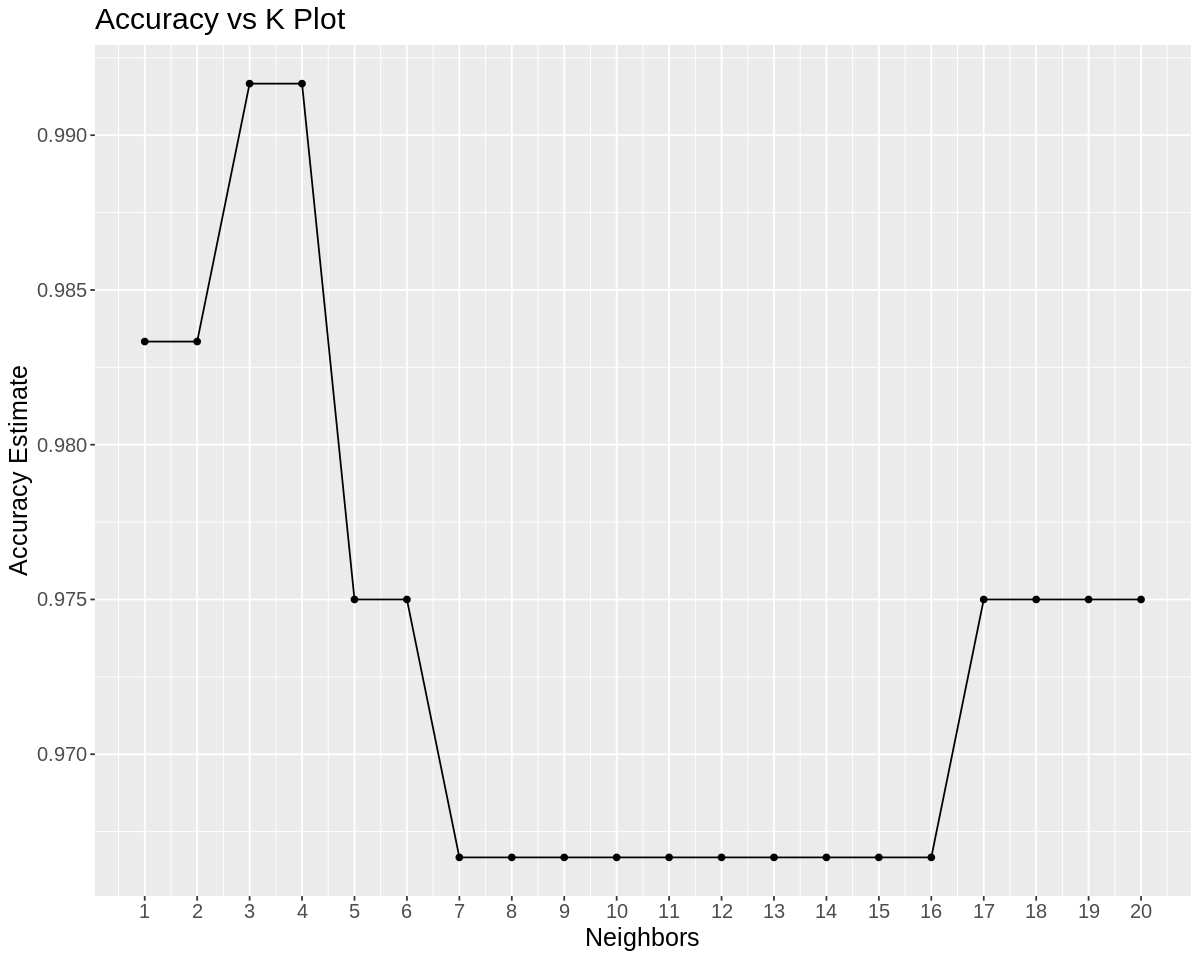

In [11]:
# plot the accuracies
accuracies_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    scale_x_continuous(breaks = 1:20) +
    labs(x = "Neighbors", y = "Accuracy Estimate", title="Accuracy vs K Plot") + 
    theme(text = element_text(size = 15))

accuracies_plot

<div style="color:gray">Figure 2: Accuracy vs K-Value Plot</div><br>

From *Figure 2*, we can see that selecting a K of 3 or 4 produces the highest accuracy.<br>
In this case, it is better to choose `K=3` as changing the K-value to a nearby neighbor results in lower decrease in accuracy than using `K=4`.

#### Final Results

Now that we chose our K-value, lets build our model and test it on the testing set.

In [12]:
set.seed(144)

# we use k=3 for our model
iris_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
  set_engine("kknn") |>
  set_mode("classification")

# fit the data to the iris_train
iris_fit <- workflow() |>
  add_recipe(iris_recipe) |>
  add_model(iris_spec) |>
  fit(data = iris_train)

# predict model on iris test
iris_predictions <- predict(iris_fit, iris_test) |>
  bind_cols(iris_test)

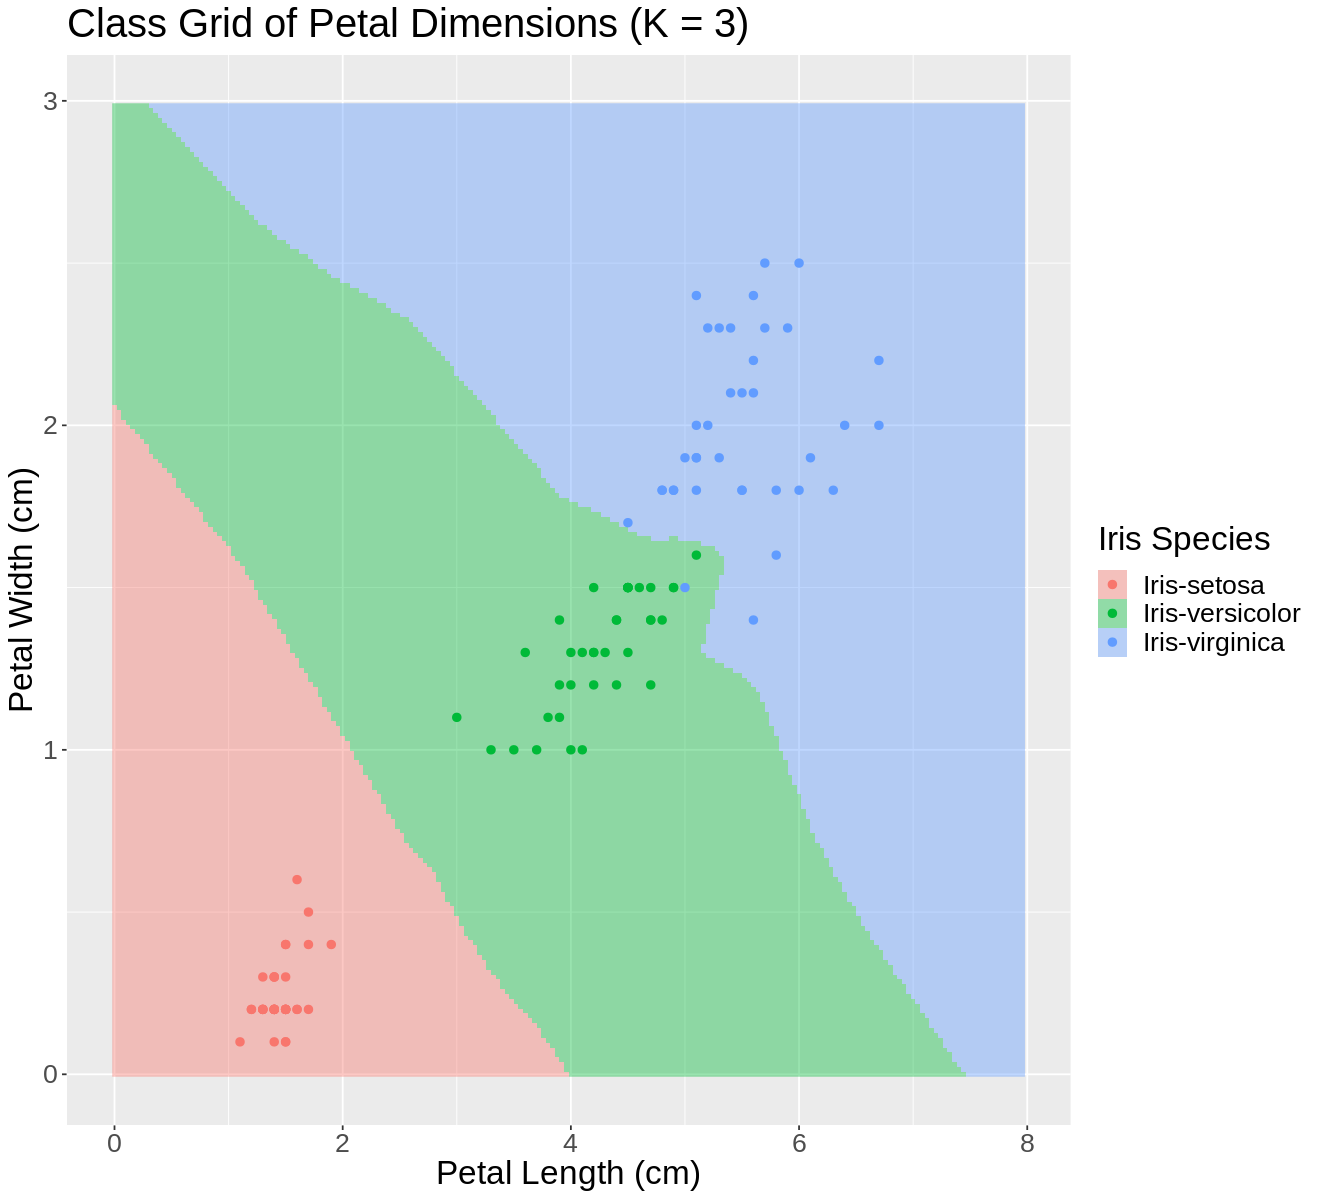

In [13]:
options(repr.plot.width = 11, repr.plot.height = 10)
# home made class grid

# plot dimensions
max_x <- 8
max_y <- 3
# grid resolution (NxN)
resolution <- 200

# calculation for x and y step size
res_x <- 1 / resolution * max_x
res_y <- 1 / resolution * max_y

# create the grid
class_grid <- tibble(i = 0:(resolution * resolution - 1)) |>
    mutate(petal_length = (i %% resolution) * res_x,     # x
           petal_width  = floor(i / resolution) * res_y) # y

# model predictions for each grid value
class_grid_predictions <- predict(iris_fit, class_grid) |>
    bind_cols(class_grid)

# plot iris testing data against grid predictions
class_plot <- ggplot() +
    geom_raster(data = class_grid_predictions, aes(x = petal_length, y = petal_width, fill = .pred_class), alpha = 0.4) +
    geom_point(data = iris_train, aes(x = petal_length, y = petal_width, color = class), size = 2) +
    labs(title = "Class Grid of Petal Dimensions (K = 3)", x = "Petal Length (cm)", y = "Petal Width (cm)", fill = "Iris Species", color = "Iris Species") +
    theme(text = element_text(size=20))

class_plot

<div style="color:gray">Figure 3: Class Grid of Final Model</div><br>

In *Figure 3*, we see that our model seperates the boundaries between each species quiet well.<br>
The boundaries isn't too noisy and the general trend of our data is respected.<br>
From this, we can conclude that `K=3` isn't overfitting/underfitting significantly.

In [14]:
# confusion matrix
iris_confusion <- iris_predictions |>
    conf_mat(truth = class, estimate = .pred_class)

iris_confusion

                 Truth
Prediction        Iris-setosa Iris-versicolor Iris-virginica
  Iris-setosa              13               0              0
  Iris-versicolor           0              11              1
  Iris-virginica            0               2             12

<div style="color:gray">Table 5: Confusion Matrix</div><br>

From *Table 5*, we can see that our model sometimes mistakes Iris Versicolor for Iris Virginica, and vice versa.<br>
This makes sense as some data points of Iris Versicolor and Iris Virginica seem quite close together (we can see this on *Figure 3*).<br>
Iris Setosa seems to be predicted accurately as it's points are located further away from the other two classes. 

In [15]:
# get the accuracy of our model!
iris_metrics <- iris_predictions |>
  metrics(truth = class, estimate = .pred_class) |>
  filter(.metric == "accuracy")

iris_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9230769


<div style="color:gray">Table 6: Model Accuracy on Testing Set</div><br>

Finally, we get an accuracy estimate of about `92.3%` when predicted over the testing set!

## Discussion

#### Pros and cons of our model
##### Pros:
- There is a clear pattern between the 3 different irises' petal dimensions.
- Since we only used 2 predictors, it was easy to visualize our results.
- The classes of our dataset were perfectly balanced, negating any issues brought by class imbalance.

##### Cons:
- Due to the small dataset of only 150 observations, our model's effectiveness depends highly on what few observations we trained it on.
- Furthermore, our testing set accuracy may not reflect real-world accuracies too well due to the small sample size.

#### How can we better our model?
As our model is limited severely by the number of observations, having more data could help improve our model significantly. Furthermore, adding more variables to the dataset and not only relying on the lengths and widths of the petals could improve our model. Possible variables to add to this dataset could be the dimensions of the flower's pistils, stamen, style, or receptacle (American Museum of Natural History).

#### Findings
We can see that by conducting a machine learning model on the dimension of iris flower sepals to classify the different species of iris flowers (Sentosa, Versicolor, Virginia), we can create an approximation of their size to easily identify them without any extraneous instruments. We are quite pleased with our model, as we can approximate with a `92%` accuracy what species certain iris flowers belong to.

This is around the accuracy we expected for our model as our exploratory data analysis revealed that the petal dimensions were sufficiently varying. An interesting observation that we didn't expect is that the sepal lengths across the 3 iris species are quite similar whilst the petal dimensions differ greatly. Another noteworthy pattern that we didn't expect is that there seems to be a positive correlation between petal length and petal width, as seen in *Figure 3*.

#### Impact

Our model can help researchers differentiate the species between our three very similar irises. Furthermore, our model provides valuable insights as to the specific characteristics that make each iris unique. This may help researchers develop more effective classification models. Moreover, our findings could be used to improve the accuracy of existing plant classification models.

More importantly, these findings serve as a stepping stone for future models to come. These future systems could classify a multitude of iris flowers, or even various genera of plants. Another extremely useful model, stemming from our findings, could help biologists classify newly discovered species of plants to their genus.

#### Future questions
- Is the trend where petal lengths positively correlate to petal widths consistent across other iris species? 
- It would be interesting to know whether we could apply the KNN model to other types of flowers and possibly animals.
- How would our results differ if we added new iris species into our data?
- Are there any other models that give similar or higher accuracy percentages that we could use with our current dataset?
- According to Filho and others, we can see that their method of using images rather than measurements to identify flowers also gives a similar result to ours. Does that mean AI trained on images determine iris species by their petal shapes as well, or some other reason?

## References

de Paiva Rocha Filho, I., Vasconcelos Teixeira, J. P., Lucena Lins, J. W., Honorato de Sousa, F., Chaves Sousa, A. C., Ferreira Junior, M., Ramos, T., Silva, C., do Rêgo, T. G., de Almeida Malheiros, Y., & Silva Filho, T. (2021). Iris-cv: Classifying Iris flowers is not as easy as you thought. Intelligent Systems, 254–264. https://doi.org/10.1007/978-3-030-91699-2_18

Parts of a flower: An illustrated guide: AMNH. American Museum of Natural History. (2021). Retrieved December 4, 2022, from https://www.amnh.org/learn-teach/curriculum-collections/biodiversity-counts/plant-identification/plant-morphology/parts-of-a-flower 

Fisher, R.A. “Iris Data Set.” Iris Data Set, UCI Machine Learning Repository, 1936, https://archive.ics.uci.edu/ml/datasets/iris.